# Introduction

In [1]:
import numpy as np
import ipyaudioworklet as iypaudio

j = iypaudio.AudioRecorder(filename="bbb.wav")
j

AudioRecorder(filename='bbb.wav')

In [2]:
display(j.sampleRate)
display(j.audiodata.shape)
display(j.audiodata)

44100

(119552,)

array([-5.7983398e-04, -6.2561035e-04, -5.1879883e-04, ...,
       -3.0517578e-05, -3.8146973e-04, -3.6621094e-04], dtype=float32)

## You can trigger click events of the buttons via Python program!

In [ ]:
# j.run()     # This is equivalent to "Boot RECORDER" button

In [3]:
# j.resume()  # This is equivalent to "Record" button

In [5]:
# j.suspend() # This is equivalent to "Stop" buton

## Please enjoy making your audio applications!!

cf. https://gist.github.com/naoh16/1731120

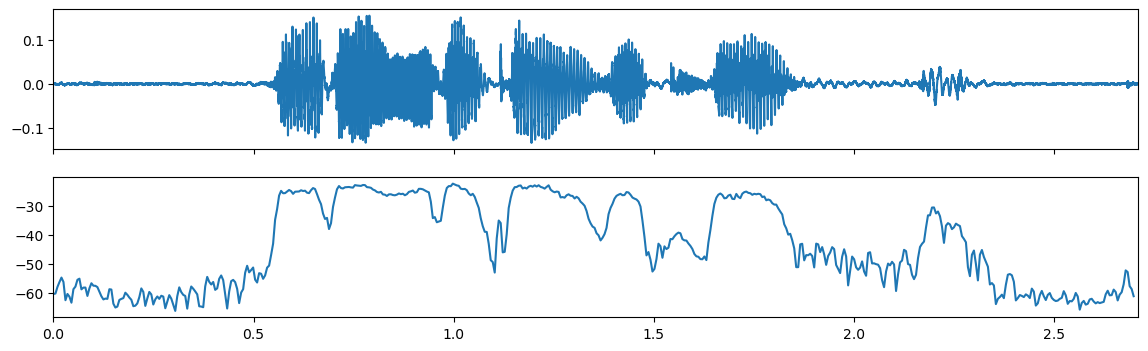

In [3]:
import matplotlib
import matplotlib.pyplot as plt

_frame_len = j.sampleRate // 100;
_frame_shift = _frame_len // 2;
_xseg = np.lib.stride_tricks.sliding_window_view(j.audiodata, _frame_len)[::_frame_shift]
x_energy = 10 * np.log10(np.mean(_xseg**2, axis=1));

ax_t0 = np.arange(len(j.audiodata)) / j.sampleRate
ax_t1 = np.arange(len(x_energy)) / j.sampleRate * _frame_shift

fig, ax = plt.subplots(2, 1, figsize=(14, 4), sharex=True)
ax[0].set_xlim(ax_t0[0], ax_t0[-1])
ax[0].plot(ax_t0, j.audiodata)
ax[1].plot(ax_t1, x_energy)
plt.show()

0 -1026.5093 0.5 -61.903028869628905 -24.57347583770752 55.73982118252125 55.73982118252125
1 -652.90283 0.520424485206604 -55.847286 -29.393335 76.66509246826172 60.81862258911133
2 -866.8684 0.5415544509887695 -55.285397 -28.837797 46.61449432373047 32.517391204833984
3 -885.5614 0.5565723776817322 -54.959564 -28.351076 48.99359130859375 26.292726516723633
4 -884.4999 0.5727435946464539 -54.545547 -27.898977 53.63248825073242 21.568111419677734
5 -881.1698 0.5887704491615295 -54.116653 -27.47452 58.81532669067383 17.499692916870117
6 -870.39734 0.6066877245903015 -53.6183 -27.029568 65.3492202758789 13.701053619384766
7 -859.4731 0.6272246837615967 -53.040947 -26.536163 73.1892318725586 9.761839866638184
8 -855.35645 0.6477652192115784 -52.44877 -26.07959 81.6465835571289 6.421517372131348
9 -861.0499 0.6643859148025513 -51.950874 -25.759314 89.20866394042969 4.375507831573486


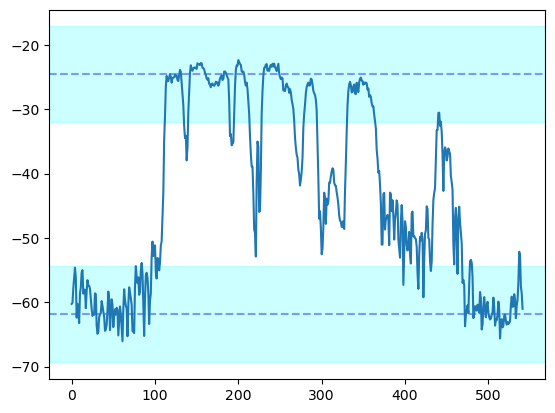

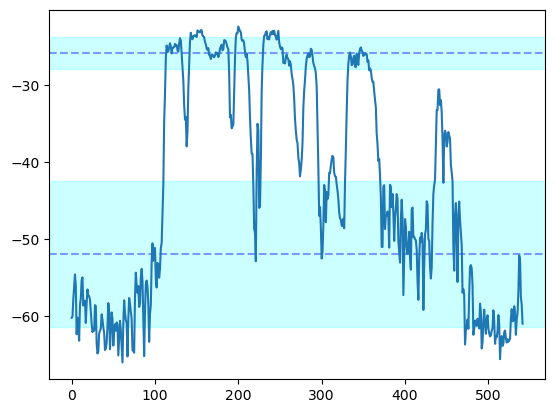

SNR_2gmm  = 26.191560745239258 dB
SNR_ptile = 37.329553031921385 dB


In [4]:
# Initial parameters
w1 = 0.5
(mu1, mu2) = np.quantile(x_energy, [0.1, 0.9])
(sigma1, sigma2) = ((0.2*(mu2-mu1))**2, (0.2*(mu2-mu1))**2)

def _gauss_prob(x, mu, sigma):
    return np.exp(-(x-mu)**2 / sigma)

def _mix_gauss_prob(x, w1, mu1, mu2, sigma1, sigma2):
    return w1 * _gauss_prob(x, mu1, sigma1) \
           + (1 - w1) * _gauss_prob(x, mu2, sigma2)

# Fig.1: Log-Energy waveform and two-mixtured GMM by initial parameters
plt.figure(1)
plt.axhline(mu1, alpha=0.4, linestyle='--', color='blue')
plt.axhline(mu2, alpha=0.4, linestyle='--', color='blue')
_s1, _s2 = np.sqrt([sigma1, sigma2])
plt.axhspan(mu1-_s1, mu1+_s1, alpha=0.2, color='aqua')
plt.axhspan(mu2-_s2, mu2+_s2, alpha=0.2, color='aqua')
plt.plot(x_energy)

LAMBDA_LOWER = 0.1
SIGMA_LOWER = 1.
x_likelihood = _mix_gauss_prob(x_energy, w1, mu1, mu2, sigma1, sigma2)
print(0, np.sum(np.log(x_likelihood)), w1, mu1, mu2, sigma1, sigma2)
for k in range(1, 10):
    # E-step
    p1 = w1 * _gauss_prob(x_energy, mu1, sigma1)
    p2 = (1-w1) * _gauss_prob(x_energy, mu2, sigma2)
    ll = p1 + p2
    (g1, g2) = (p1, p2) / ll

    # # Debug
    # plt.figure()
    # plt.plot(np.arange(len(g1)), g1, label='g1')
    # plt.plot(np.arange(len(g2)), g2, label='g2')
    # plt.legend()

    # M-step
    _g1_sum = np.sum(g1)
    _g2_sum = np.sum(g2)
    w1 = np.min([np.max([_g1_sum / (_g1_sum + _g2_sum), LAMBDA_LOWER]), 1-LAMBDA_LOWER])
    sigma1 = np.max([np.sum(g1 * (x_energy-mu1)**2) / _g1_sum, SIGMA_LOWER])
    sigma2 = np.max([np.sum(g2 * (x_energy-mu2)**2) / _g2_sum, SIGMA_LOWER])
    mu1 = np.dot(g1, x_energy) / _g1_sum   # np.sum(g1 * xpow) / _g1_sum
    mu2 = np.dot(g2, x_energy) / _g2_sum   # np.sum(g2 * xpow) / _g2_sum

    # Resolve permutation
    if mu1 > mu2:
        w1 = 1. - w1
        (mu1, mu2) = (mu2, mu1)
        (sigma1, sigma2) = (sigma2, sigma1)

    # Check result
    x_likelihood = _mix_gauss_prob(x_energy, w1, mu1, mu2, sigma1, sigma2)
    print(k, np.sum(np.log(x_likelihood)), w1, mu1, mu2, sigma1, sigma2)

# Fig.2: Log-Energy waveform and two-mixtured GMM after EM training
plt.figure()
plt.axhline(mu1, alpha=0.4, linestyle='--', color='blue')
plt.axhline(mu2, alpha=0.4, linestyle='--', color='blue')
_s1, _s2 = np.sqrt([sigma1, sigma2])
plt.axhspan(mu1-_s1, mu1+_s1, alpha=0.2, color='aqua')
plt.axhspan(mu2-_s2, mu2+_s2, alpha=0.2, color='aqua')
plt.plot(x_energy)
plt.show()

_z = np.quantile(x_energy, [0.1, 0.9])
print(f'SNR_2gmm  = {mu2-mu1} dB')
print(f'SNR_ptile = {_z[1] - _z[0]} dB')